In [9]:
from modeling_rmt import RMTEncoderForSequenceClassification
import torch
import json

from pathlib import Path
from torch.utils.data import DataLoader, DistributedSampler, Dataset
import numpy as np

from transformers import AutoConfig, AutoTokenizer, HfArgumentParser, AutoModel
from matplotlib import pyplot as plt

In [10]:
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = {
    'num_mem_tokens': 10,
    'input_size': 512,
    # 'input_seg_size': args.input_seg_size,
    'model_attr': 'deberta',
    # 'backbone_cls': backbone_cls,
    'bptt_depth': -1, 
    'pad_token_id': 0,
    'cls_token_id': tokenizer.cls_token_id, 
    'sep_token_id': tokenizer.sep_token_id,
    'eos_token_id': 102,
    "data_path": "data/test.jsonl",
    "batch_size": 4,
    "gradient_accumulation_steps": 2,
    "data_n_workers": 1,
}
labels_map = {'false': 0, 'true': 1}
encode_plus_kwargs = {
    'max_length': 998,
    'truncation': True,
    'padding': 'longest',
    'pad_to_multiple_of': 1
    }

/home/admin/t5-experiments/venv/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
class HyperpartisanDataset(Dataset):
    def __init__(self, datafile, x_field='text', label_field='label'):
        if isinstance(datafile, str):
            # convert str path to folder to Path
            datafile = Path(datafile)
        self.data = []
        for line in datafile.open('r'):
            self.data += [json.loads(line)]
        self.x_field = x_field
        self.label_field = label_field

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][self.x_field]
        label = self.data[idx][self.label_field]
        return x, label

In [4]:
def collate_fn(batch):
    inputs, labels = zip(*batch)
    features = tokenizer.batch_encode_plus(list(inputs), return_tensors='pt', **encode_plus_kwargs)
    labels = np.array([labels_map[t] for t in labels])
    labels = {'labels': torch.from_numpy(labels)}
    return {**features, **labels}

In [11]:
load_path = "deberta/run_1/model_best.pth"
checkpoint = torch.load(load_path, map_location='cpu')
model = RMTEncoderForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.set_params(num_mem_tokens=10, 
                input_size=512,
                input_seg_size=998,
                model_attr=config["model_attr"],
                # backbone_cls=transformers.BartForConditionalGeneration,
                bptt_depth=-1, 
                pad_token_id=tokenizer.pad_token_id,
                cls_token_id=tokenizer.cls_token_id, 
                sep_token_id=tokenizer.sep_token_id,
                eos_token_id=config["eos_token_id"],)
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.cuda()
model.zero_grad()

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

In [6]:
test_dataset = HyperpartisanDataset('data/test.jsonl')
test_dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn)

In [7]:
for batch in test_dataloader:
    print(batch.keys())
    break

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [12]:
i = 0 
for batch in test_dataloader:
    i += 1
    if i == 5:
        batch["input_ids"] = batch["input_ids"].to("cuda")
        batch["token_type_ids"] = batch["token_type_ids"].to("cuda")
        batch["attention_mask"] = batch["attention_mask"].to("cuda")
        batch["labels"] = batch["labels"].to("cuda")
        pred = model(
            **batch,
            output_attentions=True,
            return_dict=True
            )
        break

In [13]:
# pred[1]
layer = 1
print(pred[1]['attentions'][layer][0].shape)
print(pred[1]['attentions'][layer][1].shape)

torch.Size([12, 512, 512])


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [9]:
batch["input_ids"].shape

torch.Size([1, 998])

In [10]:
len(pred)

2

In [10]:
len(pred[0]["attentions"])

12

In [13]:
pred[0]["attentions"][0].shape

torch.Size([1, 12, 512, 512])

In [14]:
tokens = [tokenizer.convert_ids_to_tokens(t_id).replace('▁', '') for t_id in batch["input_ids"][0].tolist()[-512:]]
attentions = [layer_atts[0].detach().squeeze().numpy() if layer_atts[0] is not None else None for layer_atts in pred[0]['attentions']]

In [19]:
attentions[0].shape

(12, 512, 512)

In [16]:
from utils import grad_layer_attention_map, plot_attention_weights

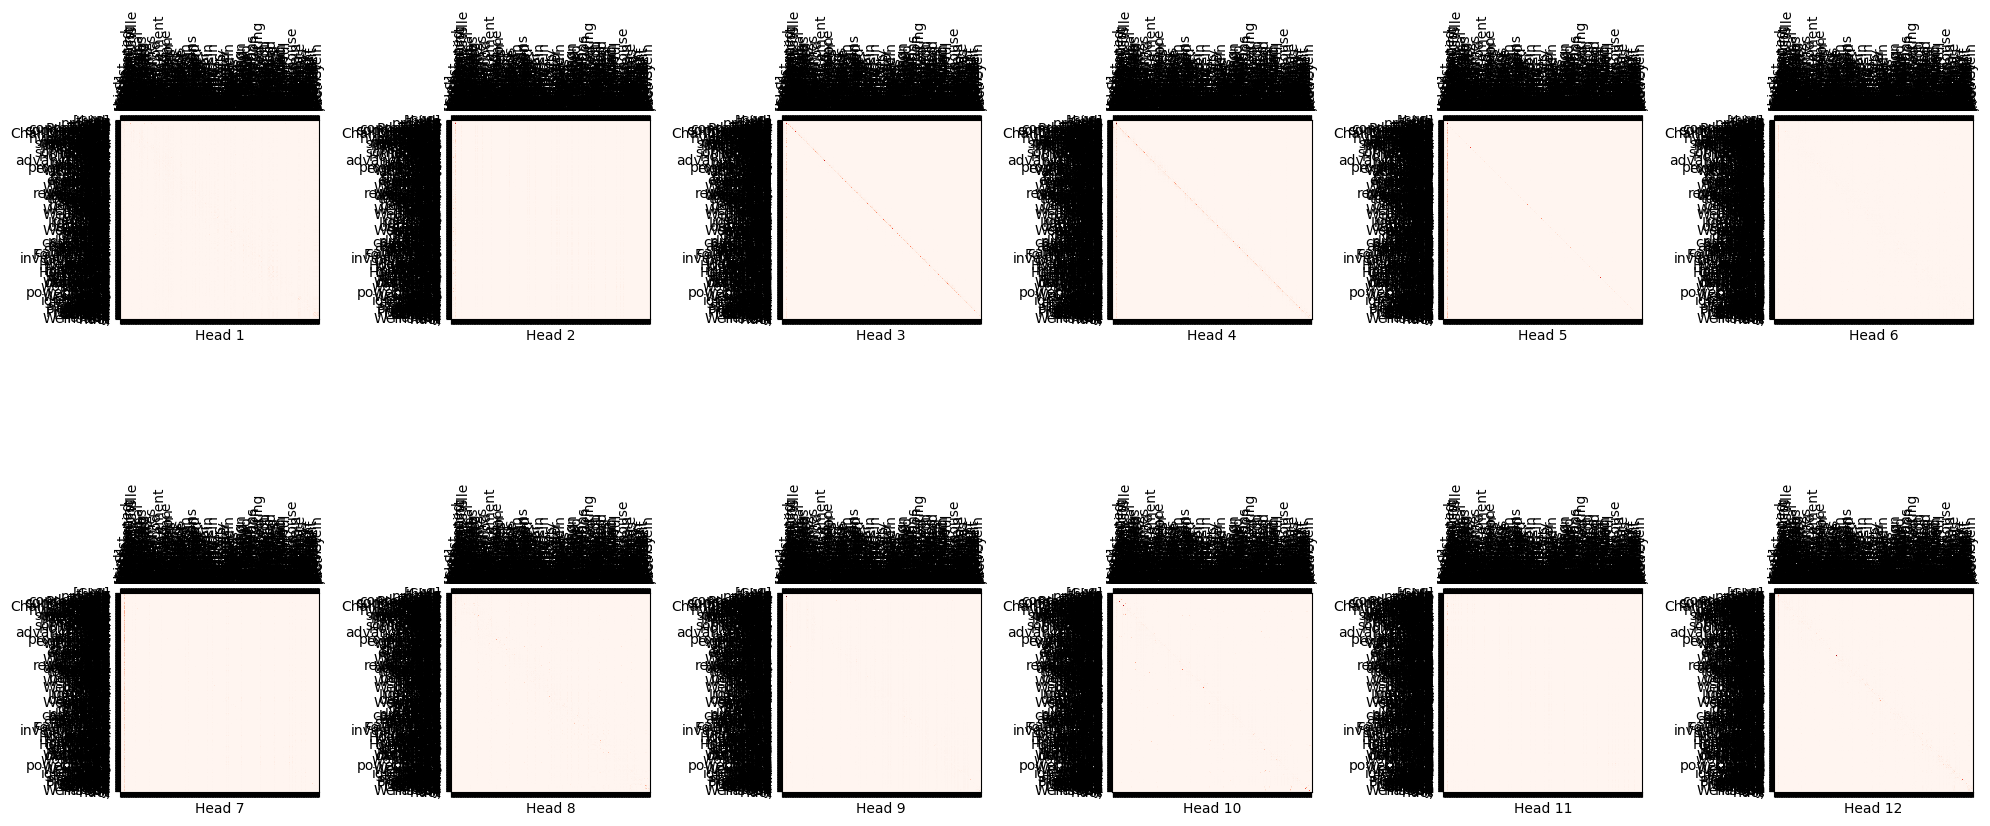

In [21]:
plot_attention_weights(attentions, tokens, layer=0, layout=(2,6), figsize=(20,10))

In [17]:
attention_maps = grad_layer_attention_map(model, batch, pred[1], tqdm_enable=True)

KeyboardInterrupt: 

: 

In [24]:
batch["attention_mask"].shape

torch.Size([1, 998])